# *add this section to READ.ME and summary table of plots*
# Kraken2 taxanomic annotation 

Kraken2 is a taxonomic classification system that uses short genomic substrings (k-mer) matches. The k-mer is matched within a query sequence with the lowest common ancestor of all genomes containing the exact k-mer. Kraken is fast and provides a taxa report for each sample. To read more about Kraken2 and install the tool visit github.com/DerrickWood/kraken2/wiki. 

This step is on Carbonate, a supercomputer, because the data set was too large to transfer to a Jetstream VM. It is possible to do this step on Jetstream, if a larger volume is requested and attached. This script will align reads against the kraken database to find the taxa. In this case, I am using sediment metagenome data sampled from hydrocarbon seepages in the Gulf of Mexico and identifying taxa families. Taxa identification is necessary to find species richness later for the rarefaction curve. Rarefaction curves are described later, after the taxa is identified and generated into a .csv table. 

** Installing kraken2 locally **

Documentation available here, 
- https://github.com/DerrickWood/kraken2/wiki
- https://blogs.iu.edu/ncgas/2019/09/24/taxa-annotation-for-shotgun-sequenced-metagenomic-data/

** Input data **

Metagenomic datasets. In this case the metagenomes were downloaded from NCBI's Sequence Read Archive (SRA) under the BioProject number PRJNA553005. There are seven sediment metagenomes under this BioProject.

** Running kraken2 command ** 

`kraken2 --db $KRAKEN_DB --use-names --report-zero-counts --paired "$f"_1.fq "$f"_2.fq --report "$f"_kraken_report`

Looking at the command above, the input samples are the forward and reverse read of the sample. Only one sample can be ran at a time using this command. In this case we had seven samples, so the command was run seven times. 

** Results from kraken2 **

This command will generate a report with the specified parameters (use-names, report-zero-counts, paired) for the sample as output. More information about Kraken2 parameters are described in the manual. The output, "$f"_kraken_report generates a table that looks like:

Sample Name | % of aligned reads | # of reads covered by clade | # of reads assigned to this taxa | rank code | NCBI Taxa ID
------------ | ------------- | ------------ | ------------- | ------------- | ------------- 
Content from cell 1 | Content from cell 2 | cell 3 | cell 4 | cell 5 | cell 6 
Content in the first column | Content in the second column | third | fourth | fifth | six 
Content in the first column | Content in the second column | third | fourth | fifth | six 
Content in the first column | Content in the second column | third | fourth | fifth | six 

Since every output is in a separate table, we need to combine them to make a rarefaction curve later. To prepare for this step, all kraken reports should be placed in thier own directory.

## Generating one output table for all the samples
Since the kraken reports currently are generated for each sample, we will need to generate one output csv or tsv table that has the taxanomic abundances for all the samples. The resulting table will be provides as input for the different visualization tools described in this notebook. 

** Download the python3 script from GitHub **

`git clone https://github.com/npbhavya/Kraken2-output-manipulation.git`

** Place all the kraken2 reports to one directory **

`mkdir kraken_report` 

`mv *_kraken_report FILEPATH/kraken_report/`

** Run the command **

`python kraken-multiple-taxa.py -d kraken_report/ -r F -c 2 -o kraken-report-final`

** Result explained **
The following command is used to get taxa information instead of taxa ID. The input -d for script the directory of kraken reports for each sample. 
-r defines taxonomic rank: (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies
-c defines the column to be included in the final report col1: number of reads covered; col2: percentage of reads covered by taxa
-o output, defines output file name

The output is a table of taxa families followed by numbers that will look something like:

        Taxa    ['sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7']
        Pseudomonadaceae        ['78249', '103170', '81428', '76970', '75855', '69162', '92573']
        Moraxellaceae   ['9420', '6299', '10383', '10311', '6685', '3269', '9622']
        Enterobacteriaceae      ['31660', '27116', '34082', '31873', '24965', '16778', '33615']

This step was run again using a different rank (Phylum) and using percentages for the alluvial plot. kraken_reports_phylum.csv

** Converting the table to csv **

`sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_final_table.csv`

The output for the csv file command should look like a table. This table is now ready to be imported to use in R scripts below. 

# Jupyter notebook

The below steps onwards the scripts and commands can be run on Jupyter notebooks. 

** Jetstream **

Jetstream is a cloud computing resource that provides access to pre-configured virtual machines (VM) with root access. Using VM’s helps with the transition of non-computer science background professionals to the command line, software installs and onto running analysis on LINUX environment (as most HPC clusters).  For more on Jetstream, go https://kb.iu.edu/d/bfde.

** Setting up Jupyter notebook on Jetstream instance ** 

A medium Ubuntu 18.04 instance was launched and Jupyter notebooks was installed following https://blogs.iu.edu/ncgas/2020/06/15/installing-jupyter-notebook-on-jetstream/. Select a instance size depending on your dataset. In additon, a 100 GB volume was attached. Request a larger volume if needed. The final kraken report in .csv format was transferred to the volume. 

***

## Rarefraction curve 

** Introduction **

A rarefaction curve shows species richness of a sample to determine if a sample is representative of a larger population by plotting the sample size and species. A rarefaction curve showing a respresentative sample will grow rapidly and then slowly plateau. The rapid growth shows how every read in the sample identifies as a new organism and the plateau shows the rare species in the sample that remain to be sampled. If your samples do not reach a plateau, it is suggested that most species in the sample are rare; Increasing the sample size will create a better respresentation of the larger population.   
In regard to our data, we are making a rarefaction curve to determine if the sediment metagenome samples are respresentative of the larger population in the Gulf of Mexico.

Before plotting a rarefaction curve, it is necessary to identify taxa using Kraken2 or another taxa identification tool because this information is neccessary to calculate species richness. The .csv table generated from the kraken reports will be used. The input for the table will be read as a table, but then transposed and read as a data frame for the rarefaction curve.

** Installations **

- vegan

** Input files ** 

Generated "**kraken_report_final_table.csv**" table


In [1]:
#Installation of the packages if they aren't already downloaded
install.packages("vegan");

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’




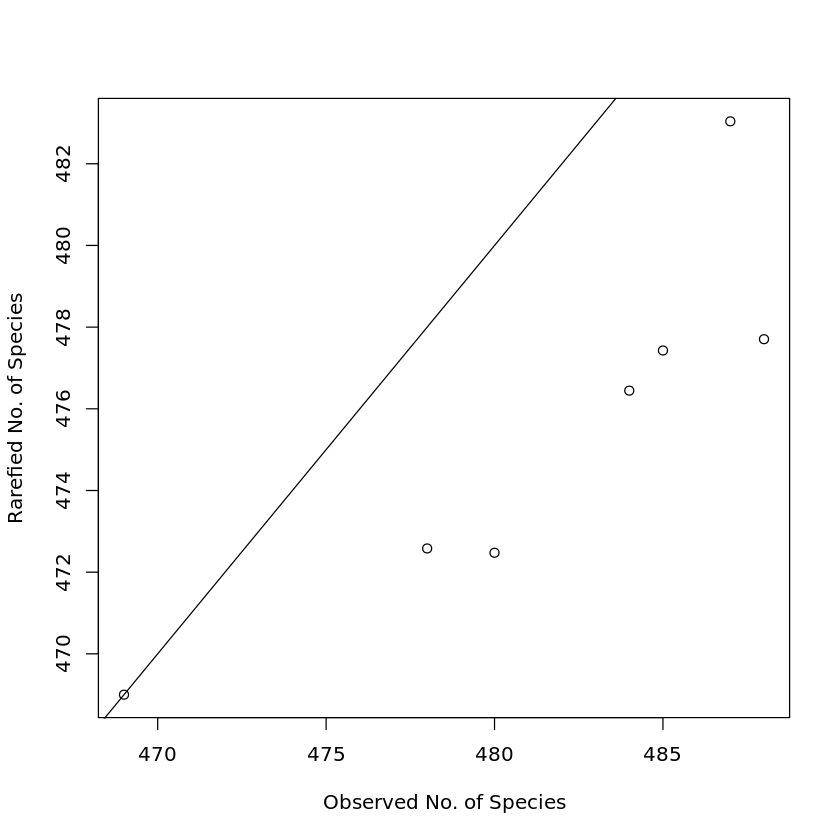

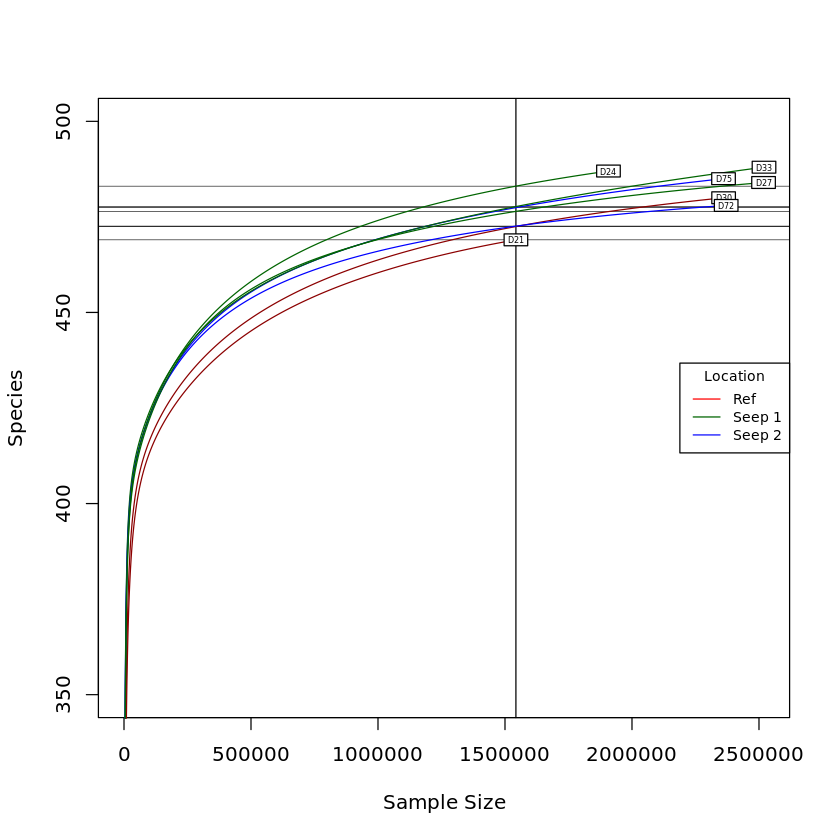

In [19]:
library(vegan);

#importing the file and parsing the file correctly
#Replace the kraken.csv name to the actual filename.
Data=read.table("kraken_report_final_taxa_table.csv", sep=",", row.names = 1, header=TRUE);

#replacing long file names with shorter ones
colnames(Data)[1:7] = c("D75","D30","D33","D72","D24","D21","D27")

Data_t=as.data.frame(t(Data));

#count the number of species
S = specnumber(Data_t);
raremax = min(rowSums(Data_t));
#print(raremax);

#Rarefaction of the samples
Srare = rarefy(Data_t, raremax);
#print(Srare);

#plotting the rarefaction curves
plot(S, Srare, xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")
abline(0, 1)
rarecurve(Data_t, step =20, sample = raremax, 
          col = c("blue", "darkred", "darkgreen", "blue", "darkgreen", "darkred", "darkgreen"), 
          cex = 0.4, ylim=c(350, 500))
legend("right", legend=c("Ref", "Seep 1", "Seep 2"),
       col=c("red", "darkgreen","blue"), lty=1, cex=0.7,
       title="Location", text.font=1)

** Graph explained **

Looking at the rarefaction curve calculated using the metagenome samples from the Gulf of Mexico above, the curve grows rapidly and then plateaus. *The y-axis starts at 350, so the actual increase of the samples is more dramatic than shown in the graph currently.* The plateau in the graph shows that no new species are being identified in the samples.  

In the plot, we can see that D21 (ref) stops short of the other samples, which means that there are less rare species in D24 compared to other samples. Similarly, D24 (transition seep 1) stops in between D21 and other samples, which shows that D24 has less rare species than other samples, but more than D21. Meanwhiles, D72, D75, D30, D27, and D33 are similar in number of species relative to the sample size.

This graph shows that the seven samples taken is a representative sample of the larger population of microbes in the Gulf of Mexico. A non-representative sample would not reach a plateau, if this happens you may need to add more samples to your data set.

** Extra information about rarefaction plots **

I changed the scale of the plot using `ylim=c(350, 500)` because the increase was sustained on the majority of the graph making the sample curves hard to analyze. To get a better view and zoom in, I changed the y axis in the `rarecurve()` function. You can also change the x axis using this argument as well, changing `ylim=c(0,0)` to `xlim`.

How to draw rarefaction curves with custom colors 
- https://fromthebottomoftheheap.net/2015/04/16/drawing-rarefaction-curves-with-custom-colours/

***

## Ordination plots
## PCA plots

** Introduction ** 

A principal component analysis (PCA) is a type of ordination plot. Ordination plots summarize data by reducing the dimensions, or variables, and plotting the samples in a format that can be visualized. A PCA plot shows the direction of maximal variation between multiple variables by condensing them into new variables, called principal components, in a data set without compromising information. A PCA plot reduces the dimensions of a matrix to show how similar or dissimilar samples are based on their distance and grouping of each other. 

For more information on ordination plots, https://ncgas.org/training/r-for-biologists-workshop.html. 

** Installations ** 

In preparation to make an ordination plot using devtools, several dependency packages also must installed. On the version of R I am using (3.4.4), the libraries for these packages are not installed. This is because it is a older version of R. The step of installing dependecy libraries in the terminal with file path to the library is neccessary or devtools will not install properly and the script won't work.

_Requirements_
- R v3.4.4
- curl libraries 
- ssl libraries 
- xml2 libraries

Download the below libraries to the instance in case they are not already installed,

    sudo apt-get install -y libcurl4-openssl-dev
    sudo apt-get install libssl-dev
    sudo apt-get install libxml2-dev 

In [25]:
#Installation of the packages if they aren't already downloaded for plotting PCA 

install.packages("gh");
install.packages("usethis");
install.packages("covr");
install.packages("roxygen2");
install.packages("rversions");
install.packages("devtools");
library(devtools)
install_github("vqv/ggbiplot") 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




ggplot2      (NA -> 3.3.2) [CRAN]
plyr         (NA -> 1.8.6) [CRAN]
scales       (NA -> 1.1.1) [CRAN]
farver       (NA -> 2.0.3) [CRAN]
labeling     (NA -> 0.3  ) [CRAN]
munsell      (NA -> 0.5.0) [CRAN]
RColorBrewer (NA -> 1.1-2) [CRAN]
viridisLite  (NA -> 0.3.0) [CRAN]
colorspace   (NA -> 1.4-1) [CRAN]
gtable       (NA -> 0.3.0) [CRAN]
isoband      (NA -> 0.2.2) [CRAN]


Installing 11 packages: ggplot2, plyr, scales, farver, labeling, munsell, RColorBrewer, viridisLite, colorspace, gtable, isoband

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpE3a5f9/remotes60654a40244c/vqv-ggbiplot-7325e88/DESCRIPTION’
─  preparing ‘ggbiplot’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘ggbiplot_0.55.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



** Below is the code to plot the PCA plot for the metagenomic datasets from the "kraken_report_final_table.csv" table **

After installing the correct packages, dependencies, and libraries, this script was used to make the PCA. 

Importance of components:
                             PC1       PC2       PC3       PC4      PC5
Standard deviation     4.464e+04 6.425e+03 3.054e+03 1.319e+03 7.24e+02
Proportion of Variance 9.741e-01 2.018e-02 4.560e-03 8.500e-04 2.60e-04
Cumulative Proportion  9.741e-01 9.943e-01 9.989e-01 9.997e-01 1.00e+00
                             PC6       PC7
Standard deviation     149.28402 3.736e-12
Proportion of Variance   0.00001 0.000e+00
Cumulative Proportion    1.00000 1.000e+00

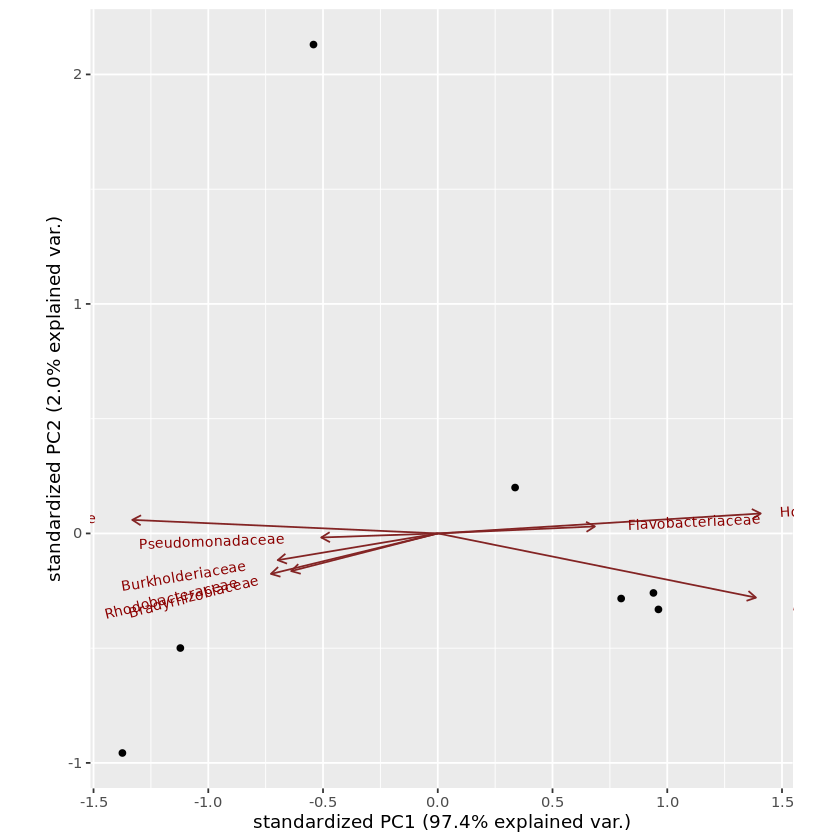

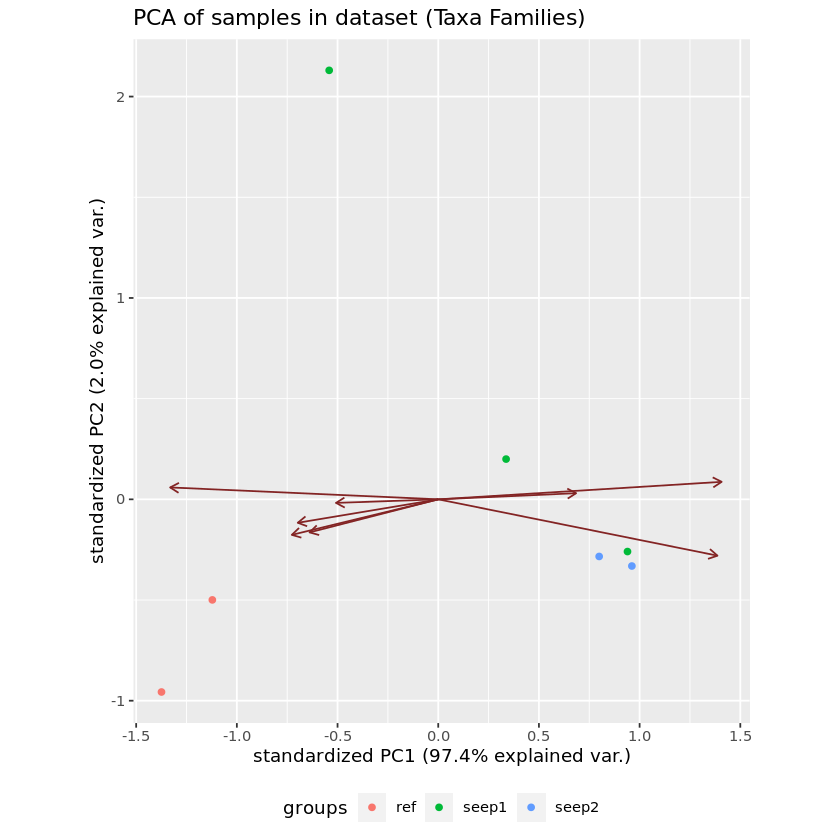

In [10]:
library(devtools)
library(ggbiplot)

#normalizing the data using raremax but slightly differently than done previously
Data_t=as.data.frame(t(Data))

raremax <-min(rowSums(Data_t))
Srare <- rrarefy(Data_t, raremax)
Srare=as.data.frame(Srare)

#step to remove the variables without a lot of variance
#removes columns with sums
Srare_clean = Srare[, colSums(Srare > 40000) > 0]

#computing the principal coordinates
data.pca=prcomp(Srare_clean, center = TRUE)
summary(data.pca)

#PCA plots  
ggbiplot(data.pca)
location=c("seep2","ref","seep1","seep2","seep1","ref","seep1")
p1 = ggbiplot(data.pca, varname.size = 0, varname.adjust = .02, ellipse = FALSE, 
         groups = location) +
ggtitle("PCA of samples in dataset (Taxa Families)") +
theme_gray() +
theme(legend.position = "bottom")

print(p1)

** Conclusions from this graph **

Looking at the plot above, we see that there are five taxa families (Streptomycetaceae, Pseudomonadaceae, Burkholderiaceae, Rhodobaceraceae, Bradyrhizobiaceae) are more correlated with reference samples while three families (Hominidae, Methanosarcinaceae, Flavobacteriaceae) are more correlated with seeps. These taxa families were labeled after saving the plot because a couple of the names wrote off the plot and were unreadable. Adding labels after on Powerpoint or another program will help ensure clarity when reading the plot. 

This plot shows that Seep 2 samples are clustered together which means that they are more correlated compared to the other samples. Similarly, the reference samples are cluster together showing their correlation compared to other samples. Lastly, seep 1 sample (D24) seems uncorrelated because it does not cluster near the reference or seep samples and is plotted far and above all the samples. 

## non-metric Multidimensionality Scaling (nMDS)

This is another ordination plot that visualizes the data based on the similarity distance from each other. 

** Introduction **

MDS plots maps the position of the samples with n dimensions, by calculating a proximity matrix. The farther the samples are away from each other, the more different they are. 

** Installation ** 
- vegan package (should be already installed if you ran rarefaction curves section)

** Input data ** 

Normalized data. 
In this case it is the the kraken family level abundances that was normalized based on species richness using the rrarefy function 

Run 0 stress 0 
Run 1 stress 9.477379e-05 
... Procrustes: rmse 0.1161976  max resid 0.147594 
Run 2 stress 8.858709e-05 
... Procrustes: rmse 0.1615087  max resid 0.2116637 
Run 3 stress 0 
... Procrustes: rmse 0.1008424  max resid 0.1439042 
Run 4 stress 2.308059e-05 
... Procrustes: rmse 0.2006191  max resid 0.2806787 
Run 5 stress 9.748345e-05 
... Procrustes: rmse 0.1674593  max resid 0.2427274 
Run 6 stress 0 
... Procrustes: rmse 0.1178692  max resid 0.1548524 
Run 7 stress 9.143983e-05 
... Procrustes: rmse 0.2146298  max resid 0.2784759 
Run 8 stress 8.861191e-05 
... Procrustes: rmse 0.1861023  max resid 0.2366672 
Run 9 stress 0 
... Procrustes: rmse 0.1981381  max resid 0.2428852 
Run 10 stress 9.821994e-05 
... Procrustes: rmse 0.1233138  max resid 0.1645723 
Run 11 stress 9.080809e-05 
... Procrustes: rmse 0.1976728  max resid 0.2712465 
Run 12 stress 4.319962e-05 
... Procrustes: rmse 0.2096163  max resid 0.2979446 
Run 13 stress 8.438385e-05 
... Procrustes: rmse 0.1531

Warning message in metaMDS(d, distance = "bray", k = 3):
“stress is (nearly) zero: you may have insufficient data”


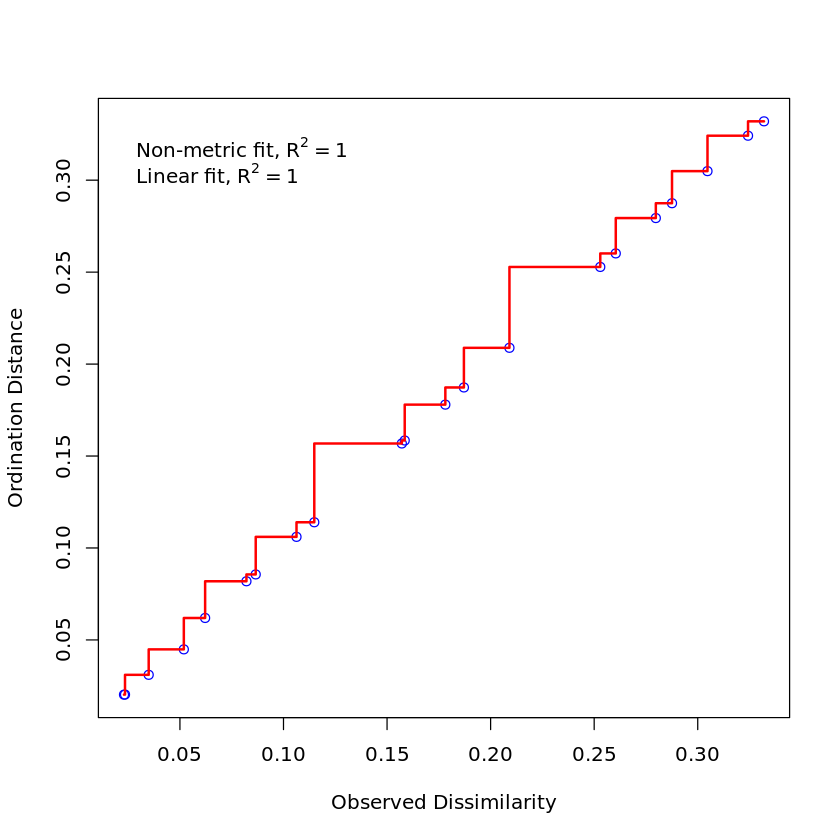

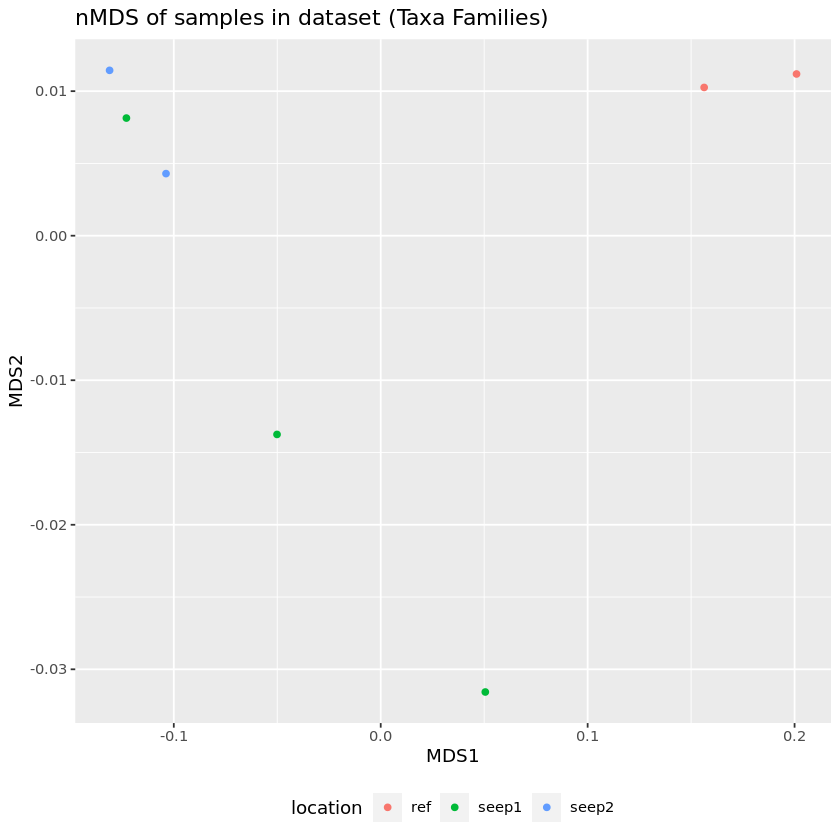

In [12]:
library(vegan)

d=vegdist(Srare, method="bray")
d_matrix=as.matrix(d, labels=T)
mds=metaMDS(d, distance = "bray", k=3) #k=number of dimensions
mds_data=as.data.frame(mds$points)
mds_data$SampleID =rownames(mds_data)

#one way to visaluze the MDS plots 
p2 = ggplot(mds_data, aes(x=MDS1, y=MDS2, color= location)) +geom_point() +
ggtitle("nMDS of samples in dataset (Taxa Families)") +
theme_gray() +
theme(legend.position = "bottom")
stressplot(mds)
print(p2)

** Conclusions from the graph **

From this graph we can determine that the two reference samples are very similar to each other as they are placed close to each other in the graph. Similarly, there are more differences within the seep samples, especially the seep 1 samples that cluster really far away from each other. In order to further gain more confidence on the representation, we can look at the goodness of fit value that determines the differences between the actual distances and predicted values. 

The second plot shows the stress value for this data. Ideally, lower stress values indicate greater conformity and therefore are desirable. High stress values indicate that there was no 2-dimensional arrangement of your points that reflect their similarities, which seems to be the case with this data. 

** So this graph or this analysis is inconclusive since the plot does not relect the data correctly ** 

Some of the reasons could be .... ??? need to fill this in! I am not sure

*tried percentages and different distance measures "euclidean" "bray" -- with same results; *

## Prinicpal Coordinate Analysis 

** Introduction **

This is another ordination plot that allows for metric dimensional scaling attempting to represent dimilarity and dissimilarity in a low dimensional space. Unlike PCA, for this analysis the input is the dis-similarity or the similarity matrix as input. 

** Input data ** 

distance matrix from the above MDS calculation from above. 
The beta diversity index is calculated from the input data to calculate the PCoA analysis.


	Homogeneity of multivariate dispersions

Call: betadisper(d = d, group = location)

No. of Positive Eigenvalues: 6
No. of Negative Eigenvalues: 0

Average distance to median:
    ref   seep1   seep2 
0.02594 0.06280 0.01746 

Eigenvalues for PCoA axes:
    PCoA1     PCoA2     PCoA3     PCoA4     PCoA5     PCoA6 
1.127e-01 1.629e-03 6.669e-04 3.554e-04 1.566e-04 4.504e-05 


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,0.002967333,0.001483666,0.9560608,0.4577552
Residuals,4,0.006207414,0.001551853,NA,NA


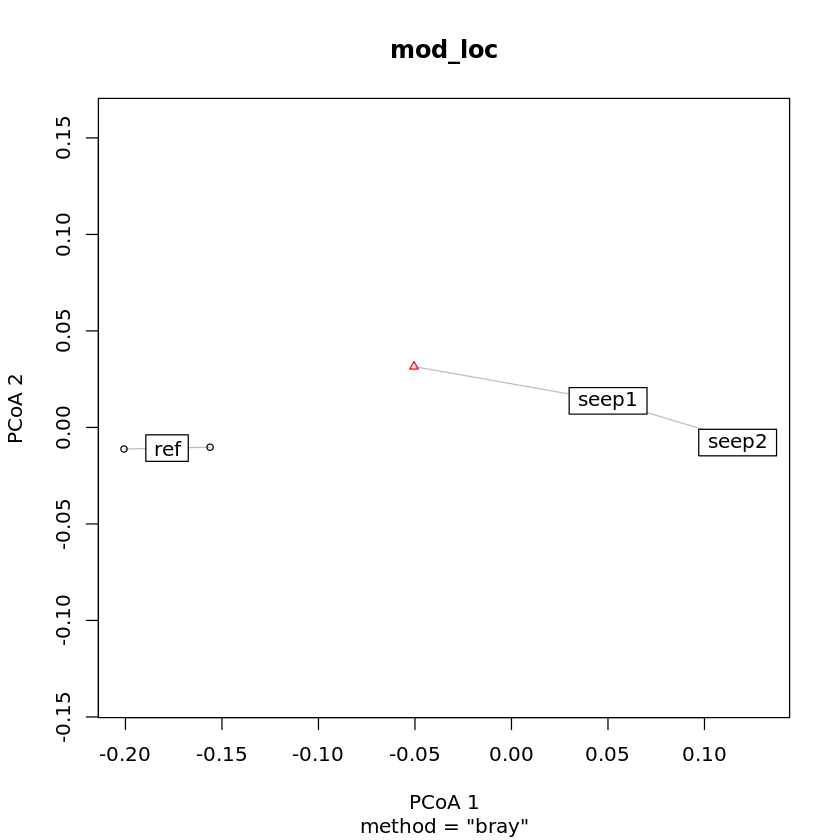

In [13]:
## Beta diversity index and PcoA plots 
## Calculate multivariate dispersions
mod_loc <- betadisper(d, location)

print(mod_loc)
#Statistical test 
anova(mod_loc)


#Plot the groups and distances to centroids on the with data ellipses instead of hulls - PCoA plots 
plot(mod_loc, ellipse = FALSE, hull = FALSE, conf = 0.90) # 90% data ellipse

** Conclusions from the graph **

From this graph we can determine that the two reference samples are very similar to each other as they are placed close to each other in the graph. Similarly, there are more differences within the seep samples but they cluster together.  


## Ordination plots conclusions 

In the three ordination plots that were made, the samples taken in the same locations cluster towards each other. This shows that although the plots use different measures, the data is displayed the same and the groupings are evident across different measurement methods in the plots. There are more detailed explainations under each plot.

***
**Some ways to save plots in Jupyter Notebook**

- as jpg

    `jpeg("rplot.jpg", width = 500, height = 500) #making jpg`
    
    `plot(mod_loc, ellipse = FALSE, hull = FALSE, conf = 0.90) # PCoA plot`
    
    `dev.off()`


- right click on graph/plot
    - "Save image as"

** Plot in one figure **

I tried this and you can view it below, but it doesnt work for PCoA beause I couldnt save the plot function like PCA and nMDS. This could be used to plot multiple PCAs or something else. 

    library(gridExtra)`
    grid.arrange(p1,p2, ncol=2)`

** Other Resources ** 

- https://www.statmethods.net/advgraphs/layout.html 
- https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html 


Below is two attempts using the above resources to plot the ordination figures into one graph. This did not exactly work out like I planned, but this information may be useful for some people which is why I am including it :) 

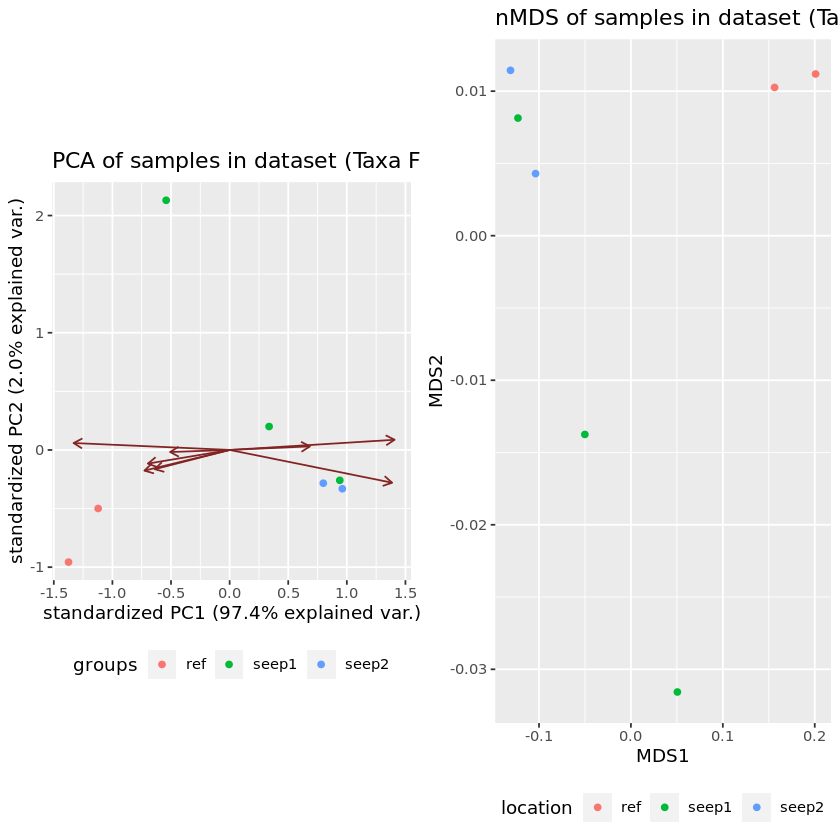

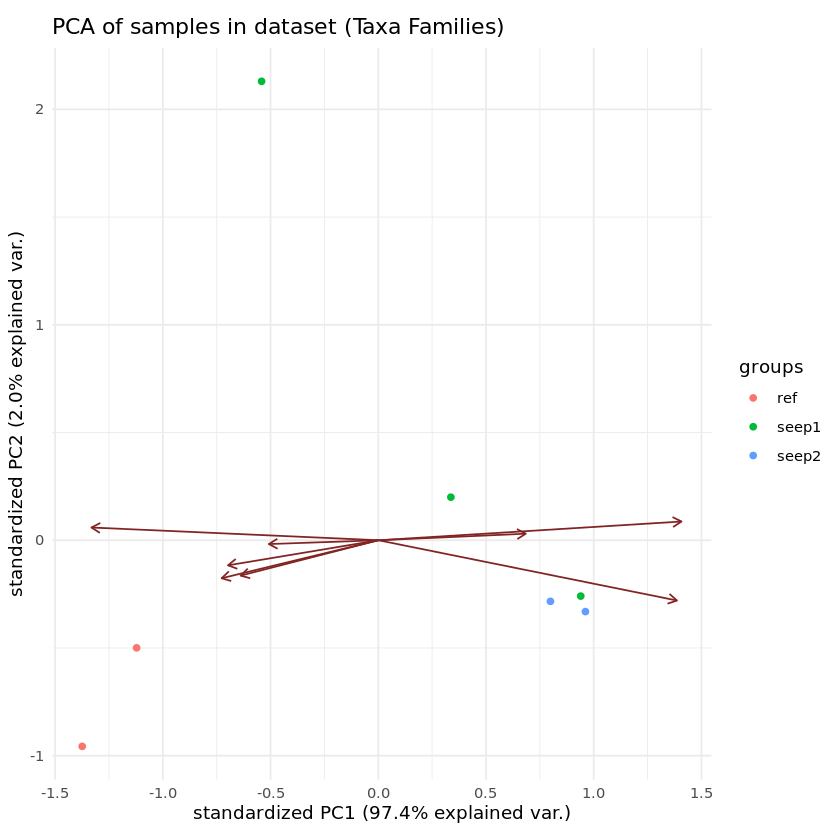

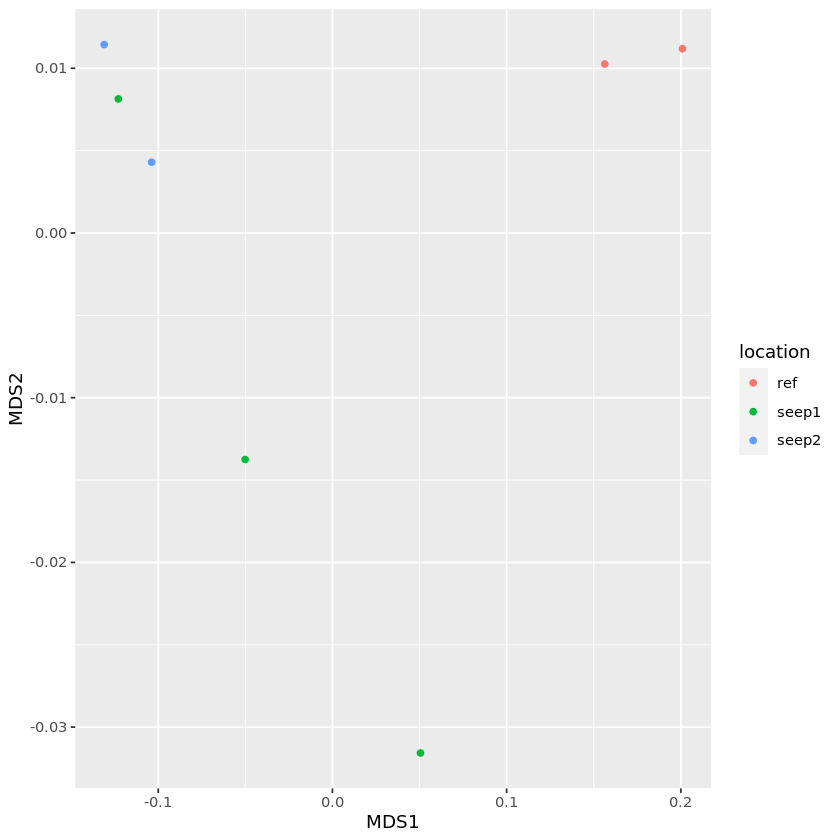

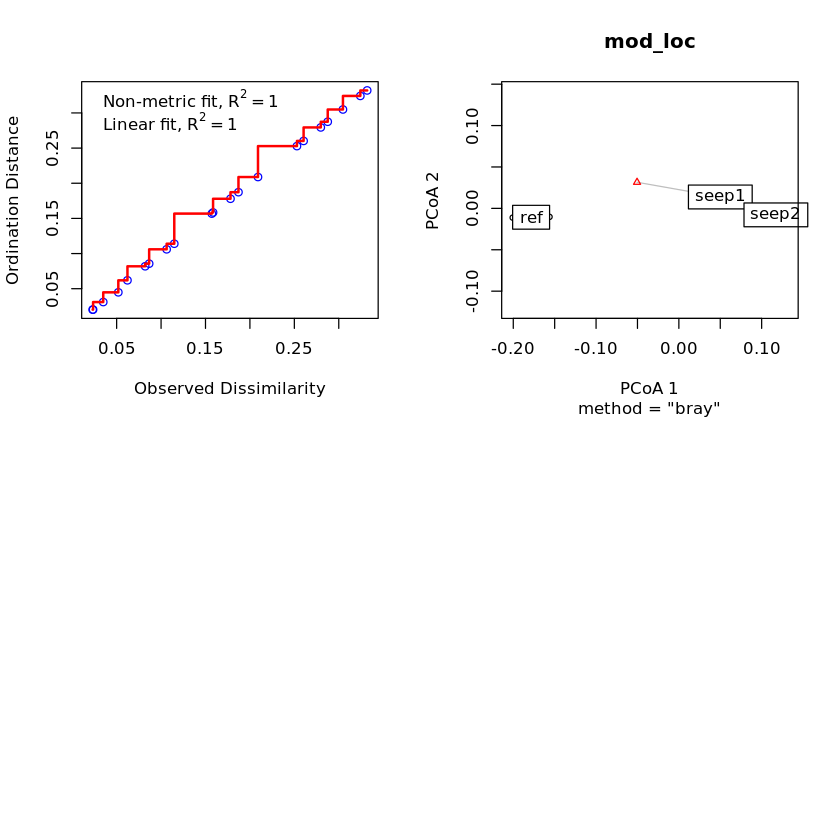

In [15]:
#combining ordination plots into one figure
#doesnt work for PCoA so i screenshotted and added labels and whatever in powerpoint

library(gridExtra)
grid.arrange(p1,p2, ncol=2)

#second way to combine plots into one figure
old.par <- par(mfrow=c(2, 2))
#pca plot
ggbiplot(data.pca, varname.size = 0, varname.adjust = 0, ellipse = FALSE, 
         groups = location) +
ggtitle("PCA of samples in dataset (Taxa Families)") +
theme_minimal() +
theme(legend.position = "right")
#nMDS plot
ggplot(mds_data, aes(x=MDS1, y=MDS2, color= location)) +geom_point()
stressplot(mds)
#pcoa plot
plot(mod_loc, ellipse = FALSE, hull = FALSE, conf = 0.90)
par(old.par)

#### ggplot features and themes

On my PCA plot, I decided to not add variable names to the eigenvectors (arrows) because the taxa family names were reading off the plot. To change the variable names and position I suggest seeing ggbiplot documentation to add labels and adjust size and placement ``varname.size = 3, varname.adjust = 1``. For me, I was able to move the variable names just enough to know what they were so I could label them after I saved my plot. This was easier/faster for me which is why I chose to do it in this way, but there seems to be ways to do this within R. 

I also changed the theme of the plots so that they would match. I did this for clarity and flow. You can do this too, just google it, or click the link to learn how to change the theme of your plot!

** different `theme_ ()` changes https://ggplot2.tidyverse.org/reference/ggtheme.html **
***

## Alluvial plot

** Introduction **

An alluvial plot is similar to a sankey diagram. Alluvial plots show how sets of groups change according to differnt dimensions. I am making this plot to show how the samples differ between each other. Or to show how each sample changes across the taxa 
families -- i am not sure yet. 

** Installation ** 
- ggaluvial package 
- ggplot2 

** Input data **

The python3 script was ran again on the kraken report directory to get taxa phylums `-r P` and percent of reads covered by taxon `-c 1`. The output of the script was converted to a .csv file as previously using `sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_phylum_percent.csv`. 

The file was reformatted to have every variable in a column. This is necessary for the alluvial plot script. Taxa phylum with low abundance was grouped into one taxa called "Other" and the phylum abundance was binned into three bins. Other variables from the data set were added such as location, thermogenic gases detected, hydrocarbons detected, and sample names from the published paper.


The input file for this script is ** phylumreformat.csv **

In [5]:
#Installation of the packages if they aren't already downloaded for alluvial plots 
install.packages("ggalluvial")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


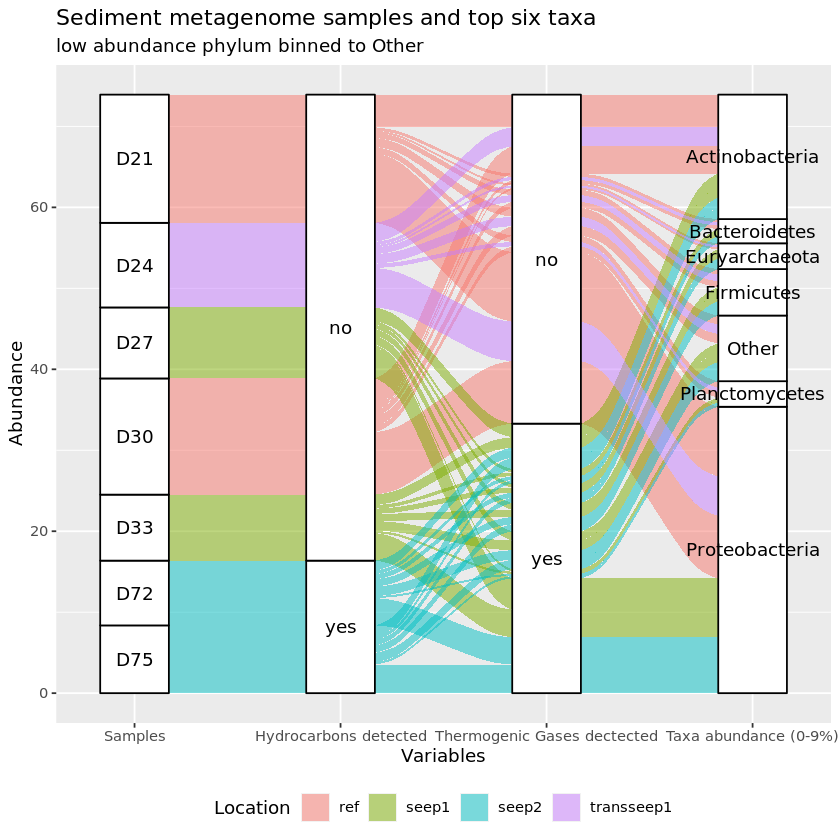

In [132]:
library(ggalluvial);
library(ggplot2);


#reformatted samples and taxa in excel to have abundances in one column to bin 
mydata=read.table("phylumreformat.csv", sep=",", header = TRUE)
#print(data)

#binnning
#not sure about open intervals; right/left=FALSE
mydata$AbundanceBin<-cut(mydata$Abundance, seq(0,9,3), right=FALSE)
#print(data)
reformat=data.frame(mydata)

#add locations/other variables to data
reformat$Location= (c("ref","ref","ref","ref","ref","ref","ref", 
                      "ref","ref","ref","ref","ref","ref","ref", 
                      "transseep1","transseep1","transseep1","transseep1","transseep1","transseep1","transseep1", 
                      "seep1","seep1","seep1","seep1","seep1","seep1","seep1",  
                      "seep1","seep1","seep1","seep1","seep1","seep1","seep1", 
                      "seep2","seep2","seep2","seep2","seep2","seep2","seep2", 
                      "seep2","seep2","seep2","seep2","seep2","seep2","seep2"))
reformat$ThermogenicGases= (c("no","no","no","no","no","no","no",
                              "no","no","no","no","no","no","no",
                              "no","no","no","no","no","no","no",
                              "yes","yes","yes","yes","yes","yes","yes",
                              "yes","yes","yes","yes","yes","yes","yes", 
                              "yes","yes","yes","yes","yes","yes","yes",
                              "yes","yes","yes","yes","yes","yes","yes"))
reformat$Hydrocarbons= (c("no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "yes","yes","yes","yes","yes","yes","yes",
                          "yes","yes","yes","yes","yes","yes","yes"))
reformat$Samples= (c("D21","D21","D21","D21","D21","D21","D21",
                          "D30","D30","D30","D30","D30","D30","D30",
                          "D24","D24","D24","D24","D24","D24","D24",
                          "D27","D27","D27","D27","D27","D27","D27",
                          "D33","D33","D33","D33","D33","D33","D33",
                          "D72","D72","D72","D72","D72","D72","D72",
                          "D75","D75","D75","D75","D75","D75","D75"))

#head(reformat)

ggplot(data = reformat,
       aes(axis1 = Samples, axis2 = Hydrocarbons, axis3 = ThermogenicGases, axis5 = Taxa,
           y = Abundance)) +
  scale_x_discrete(limits = c("Samples","Hydrocarbons detected","Thermogenic Gases dectected","Taxa abundance (0-9%)"), expand = c(.11, .05)) +
  xlab("Variables") +
  geom_alluvium(aes(fill = Location)) + 
  geom_stratum() + geom_text(stat = "stratum", infer.label = TRUE) + 
  theme(legend.position = "bottom") +
  ggtitle("Sediment metagenome samples and top six taxa",
          "low abundance phylum binned to Other")

** Conclusions from the graph **

From this graph we can see how the samples, grouped by location, flow through variables (Hydrocarbons detected, Thermogenic Gases detected, and Taxa abundance (0-9%)). The taxa abundance is 0-9% because the samples contain 88-90% unidentified reads. Sample D21 had the highest abundance of Proteobacteria across all samples being ~8.5%. This is why the taxa phylum with very low abundance were grouped into the catogory "Other".

Looking at this graph, the samples have highest abundance in Proteobacteria, which is why the section for Proteobacteria is larger compared to the other taxa in the column (stratum). Similarly, most abundance comes from many phylum with small abundances. 
    
   - Huge phylum; has bacteria important for nitrogen fixation but I should not delve into this because I cannot be sure since Proteobacteria is such a big phylum. 

We can also see that there is a larger abundance of Actinobacteria in reference samples.
    
   - Diverse roles - Antibacterial agents / antibiotics / anti-many things but again same thing since I dont know what species its hard to say their role/significance in the samples
    
Something interesting that we can see when looking at this graph is how the transition sample (D24), from seep 1, compares to the seeps and reference samples. The transition sample is similar to the seeps in that it has no hydrocarbons like seep 1 and the reference samples, and similar to the reference sample in that there were no thermogenic gases detected. 

Write something about the paper's conclusions on seep 1/transition sample D24

** More information **


- https://corybrunson.github.io/ggalluvial/articles/order-rectangles.html#more-examples-1
- http://corybrunson.github.io/ggalluvial/reference/stat_alluvium.html
***

# Heatmaps 

**Introduction**

Heatmaps are a way to summarize a table of abundances or another numerical value into a color-coded map. They can be very colorful.

**Input Data** 

- kraken_report_phylum_percent.csv

Heatmaps require a matrix with the taxa phylum as rows and the samples in one column. We must transform our initial taxa classification table and change it into a matrix. I put an example of a few rows and columns of how the data should look as a matrix below: 

| Taxa | Proteobacteria | Actinobacteria | Firmicutes | Cyanobacteria | Chloroflexi |
|-|-|-|-|-|-|
| **sample1** | 3.53 | 1.41 | 0.88 | 0.24 | 0.12 |
| **sample2** | 7.72 | 3.37 | 0.73 | 0.18 | 0.11 |
| **sample3** | 3.41 | 1.29 | 0.90 | 0.25 | 0.12 |

- https://www.tablesgenerator.com/markdown_tables

,Proteobacteria,Actinobacteria,Firmicutes,Planctomycetes,Bacteroidetes,Euryarchaeota,Other
SRR9649754,8.58,4.04,0.67,0.80,0.39,0.25,1.10
SRR9649757,7.72,3.37,0.73,0.71,0.42,0.23,1.17
SRR9649755,4.88,2.35,0.84,0.53,0.41,0.27,1.17
SRR9649756,3.88,1.68,0.83,0.30,0.43,0.52,1.13
SRR9649758,3.41,1.29,0.90,0.28,0.44,0.64,1.19
SRR9649759,3.37,1.23,0.89,0.25,0.46,0.62,1.18


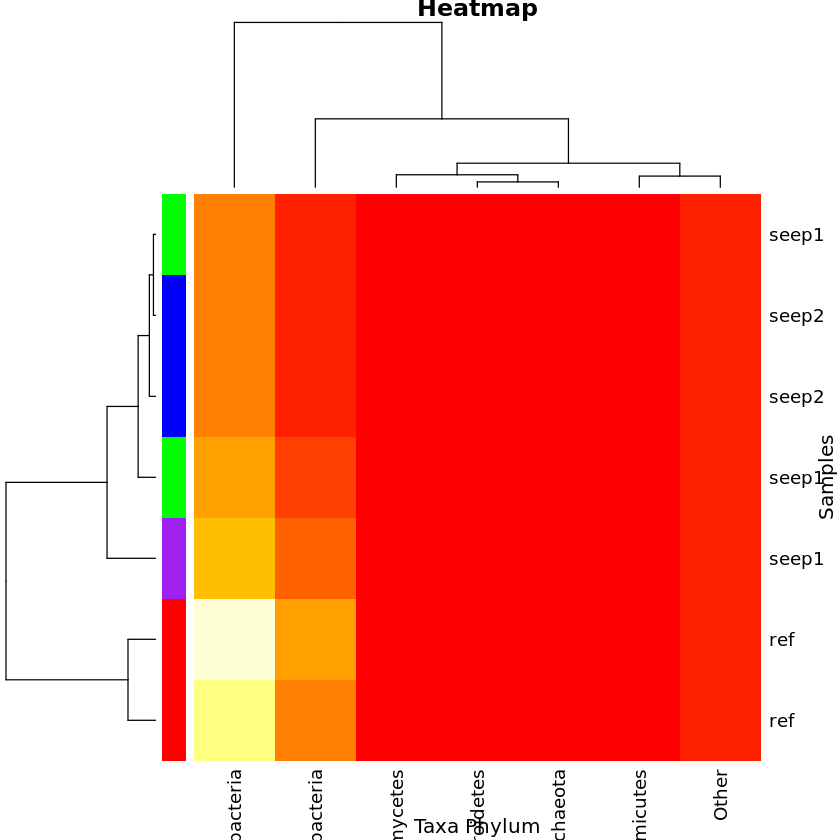

In [23]:
library(stats)
#most basic heatmap

all.data <- read.csv("grouped_other.csv", row.names = 1)  # load the data w row names 
all.data1 = t(all.data) #transpose data to have samples in one column and taxa names in first row

my_matrix <- as.matrix(all.data1)
head(my_matrix)
#class(my_matrix) #see data type


heatmap(my_matrix, scale = "none", labRow = c("ref","ref","seep1","seep1","seep1","seep2","seep2"), 
       main = "Heatmap", xlab = "Taxa Phylum", ylab = "Samples",
       RowSideColors = c("red","red","purple","green","green","blue","blue"))

,Pseudomonadaceae,Moraxellaceae,Enterobacteriaceae,Yersiniaceae,Pectobacteriaceae,Erwiniaceae,Morganellaceae,Hafniaceae,Budviciaceae,Xanthomonadaceae,⋯,Spiraviridae,Alphasatellitidae,Bidnaviridae,Clavaviridae,Guttaviridae,Globuloviridae,Nanoviridae,Asfarviridae,Corticoviridae,Tectiviridae
X.N.dc2.scratch.hleffler.kraken_report.SRR9649760_kraken_report,78249,9420,31660,10822,8013,5890,5324,2475,435,31331,⋯,0,0,0,0,0,0,0,0,0,0
X.N.dc2.scratch.hleffler.kraken_report.SRR9649757_kraken_report,103170,6299,27116,10059,6003,5852,2924,1949,487,42466,⋯,0,1,0,0,0,0,1,5,0,0
X.N.dc2.scratch.hleffler.kraken_report.SRR9649758_kraken_report,81428,10383,34082,11797,8659,6369,6035,2853,502,32098,⋯,0,2,0,0,0,0,1,0,1,0
X.N.dc2.scratch.hleffler.kraken_report.SRR9649759_kraken_report,76970,10311,31873,11142,8305,5712,5840,2516,404,30782,⋯,0,1,0,0,0,0,3,0,0,0
X.N.dc2.scratch.hleffler.kraken_report.SRR9649755_kraken_report,75855,6685,24965,8788,5304,5444,3204,1605,418,28960,⋯,0,2,0,0,0,0,3,0,0,1
X.N.dc2.scratch.hleffler.kraken_report.SRR9649754_kraken_report,69162,3269,16778,6248,3641,3456,1541,1228,254,29294,⋯,0,0,0,0,0,1,0,0,0,0


[1]  7 34

[1] 505

[1] 505

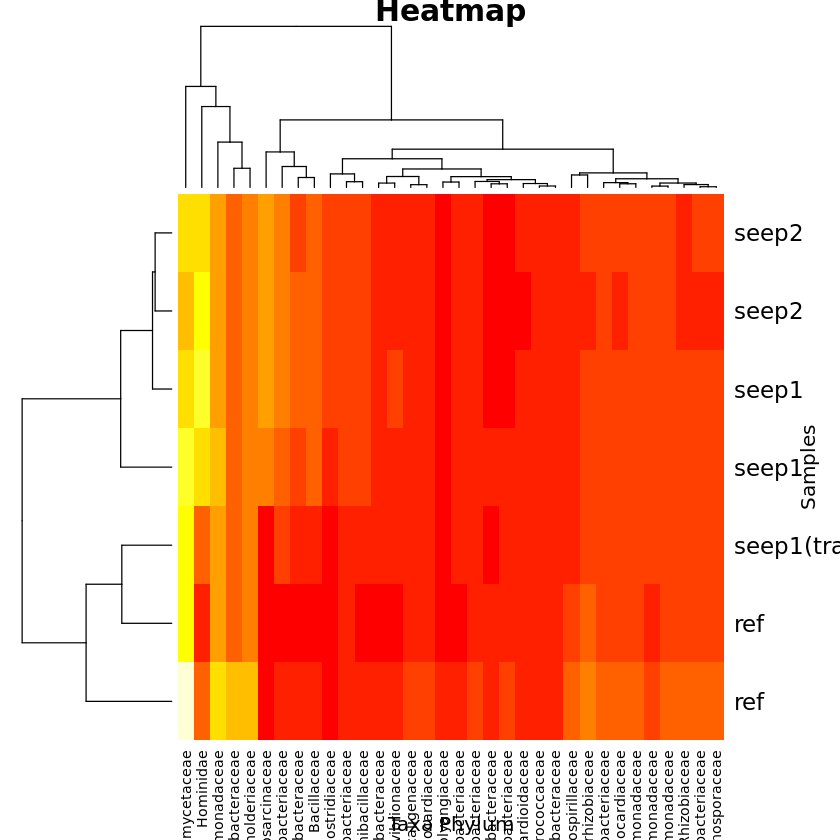

In [22]:
#trying the same package with number of reads instead of %
library(stats)
#most basic heatmap

mytable <- read.csv("kraken_report_final_taxa_table.csv", row.names = 1)  # load the data w row names 
mytablet = t(mytable) #transpose data to have samples in one column and taxa names in first row

my_matrix1 <- as.matrix(mytablet)
head(my_matrix1)
#class(my_matrix1) #see data type

#total abundances of each family
s_abundances<-apply(my_matrix1,2,sum)

#highs and lows of abundances 
bads<-my_matrix1[,s_abundances<100000]
goods<-my_matrix1[,s_abundances>100000]

dim(goods)

#sees how many colums will be removed 
ncol(my_matrix1)-ncol(goods)
ncol(bads)

heatmap(goods, scale = "none", labRow = c("seep2","ref","seep1","seep2","seep1(trans)","ref","seep1"), 
       main = "Heatmap", xlab = "Taxa Phylum", ylab = "Samples")

**Conclusions from heatmap**

add things





*useful links I'm finding along the way* 
- different types of heat map packages https://www.datanovia.com/en/lessons/heatmap-in-r-static-and-interactive-visualization/
***